In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

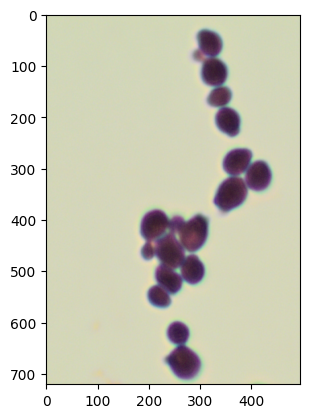

In [2]:
image_name = "./dataset/png/Candida.albicans_0017.png"
image = cv2.cvtColor(cv2.imread(image_name), cv2.COLOR_BGR2RGB)
plt.imshow(image)

* K-means clustering

Ref: https://machinelearningknowledge.ai/image-segmentation-in-python-opencv/ \
Doc K-means: https://docs.opencv2.org/3.4/d1/d5c/tutorial_py_kmeans_opencv2.html

In [3]:
#Target class number
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3 #Trying to find BG / general contours / bacteria
attempts = 10

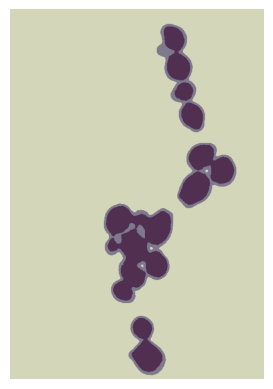

In [4]:
image_as_array = np.float32(image.reshape((-1,3)))

compactness, label, center = cv2.kmeans(image_as_array, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((image.shape))

plt.axis('off')
plt.imshow(result_image)

In [5]:
from cv2 import Mat

def execute_kmeans(image: Mat) -> Mat:
    image_as_array = np.float32(image.reshape((-1,3)))

    _, label, center = cv2.kmeans(image_as_array, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    result_image = res.reshape((image.shape))

    return result_image

Remove ""noise"" between bacterias by detecting and suppressing middle channel

Centers found: 
[[211 214 184]
 [ 80  47  81]
 [126 120 142]]
Averages found: [203.0, 69.33333333333333, 129.33333333333334]
Detected center indexes: min=1, med=2, max=0


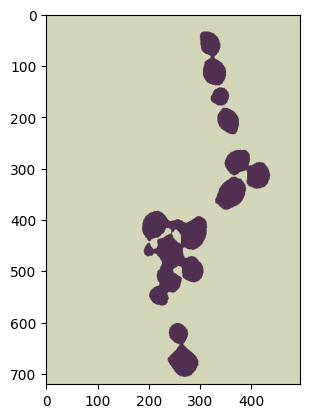

In [6]:
working_image = image.copy()

image_as_array = np.float32(working_image.reshape((-1,3)))

_, label, center = cv2.kmeans(image_as_array, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)

averages = [np.mean(c) for c in center]

print(f"Centers found: \n{center}")
print(f"Averages found: {averages}")

min_index = np.argmin(averages)
max_index = np.argmax(averages)
med_index = list(set((0,1,2)) - set((min_index, max_index)))[0]

print(f"Detected center indexes: min={min_index}, med={med_index}, max={max_index}")

#Suppress medium center directly in center array
center[med_index] = center[max_index] #Replace by background

res = center[label.flatten()]
suppressed_image = res.reshape((image.shape))
plt.imshow(suppressed_image)

Trivial binarization

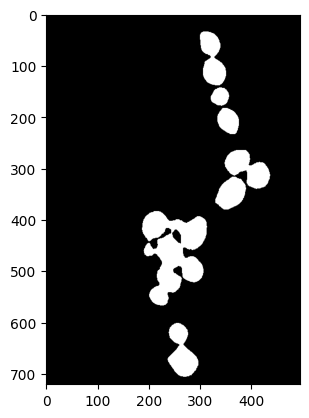

In [7]:
gray_image = cv2.cvtColor(suppressed_image, cv2.COLOR_RGB2GRAY)
gray_image = cv2.GaussianBlur(gray_image, (5,5), 0)
_, binarized_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(binarized_image, cmap='gray', vmin=0, vmax=255)

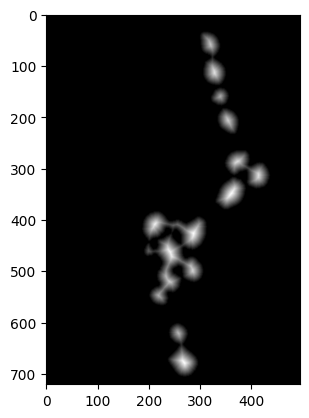

In [8]:
dist_transform = cv2.distanceTransform(binarized_image, cv2.DIST_L2, 3, dstType=cv2.CV_8U)
cv2.normalize(dist_transform, dist_transform, 0, 255, cv2.NORM_MINMAX)
plt.imshow(dist_transform, cmap='gray', vmin=0, vmax=255)

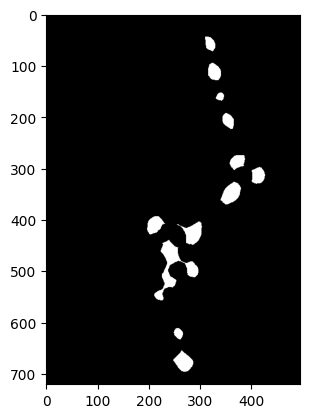

In [9]:
_, dist = cv2.threshold(dist_transform, 100, 255, cv2.THRESH_BINARY)

plt.imshow(dist, cmap='gray', vmin=0, vmax=255)

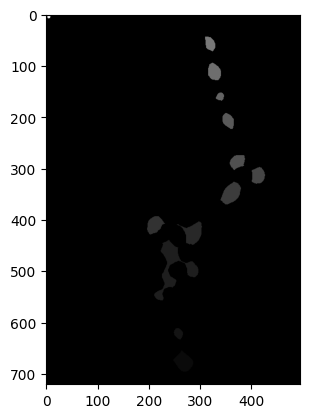

In [10]:
# Create the CV_8U version of the distance image
# It is needed for findContours()
dist_8u = dist.astype('uint8')
# Find total markers
contours, _ = cv2.findContours(dist_8u, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Create the marker image for the watershed algorithm
markers = np.zeros(dist.shape, dtype=np.int32)
# Draw the foreground markers
for i in range(len(contours)):
    cv2.drawContours(markers, contours, i, (i+1), -1)
# Draw the background marker
cv2.circle(markers, (5,5), 3, (255,255,255), -1)
markers_8u = (markers * 10).astype('uint8')

plt.imshow(markers_8u, cmap='gray', vmin=0, vmax=255)

In [11]:
from random import randint

# Perform the watershed algorithm
watershed_result = cv2.watershed(suppressed_image, markers)
#mark = np.zeros(markers.shape, dtype=np.uint8)
mark = markers.astype('uint8')
mark = cv2.bitwise_not(mark)
# Generate random colors
colors = []
for contour in contours:
    colors.append((randint(0,256), randint(0,256), randint(0,256)))
# Create the result image
dst = np.zeros((markers.shape[0], markers.shape[1], 3), dtype=np.uint8)
# Fill labeled objects with random colors
for i in range(markers.shape[0]):
    for j in range(markers.shape[1]):
        index = markers[i,j]
        if index > 0 and index <= len(contours):
            dst[i,j,:] = colors[index-1]

# Visualize the final image
print(f"Found {len(contours)} bacterias")
plt.imshow(dst)

TypeError: len() takes exactly one argument (0 given)

# Show marker outlines on original image

In [ ]:
result_image = image.copy()
result_image[watershed_result == -1] = [255,0,0]
plt.imshow(result_image)

In [ ]:
plt.imshow(watershed_result)